In [64]:
!pip install underthesea --quiet
!pip install sklearn_crfsuite --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
import nltk
import numpy as np
import pandas as pd
import underthesea
import re
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn_crfsuite import CRF

In [66]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [67]:
def read_file(file_name):
    return open(file_name, 'r', encoding='utf-8').read().split('\n')

def write_file(file_name, text):
    file = open(file_name, 'w', encoding='utf-8')
    for sentences in text:
        file.writelines(sentences + '\n')

In [68]:
def inspect_tag(tag) -> bool:
    pattern = re.compile(r'^[A-Z][a-z]?$')
    return bool(pattern.search(tag))

In [69]:
def inspect_word(word) -> bool:
    pattern = re.compile(r'[!"#$%&\'()*+,-./:;<=>?@\[\]^`{|}~“”\\]+')
    return not(bool(pattern.search(word)))

In [70]:
def get_raw_text(filename):
    """
    - trả về data nguyên bản (kể cả các invalid word, tag) trong file
    - bên cạnh đó, xử lí word và tag -> tách tag và word sau đó kẹp thành 1 tuple như này (word, tag)
    - loại bỏ các word không tag hoặc word có nhiều hơn 1 tag
    """ 
    text = read_file(filename)
    data = []

    for sentence in text:
        for duo in sentence.strip().split(' '):
            data.append(tuple(duo.split('/')))

    data = [duo for duo in data if len(duo) == 2]
    return data

In [71]:
def get_processed_data(filename):
    opening = ('<s>', '<s>')
    ending = ('</s>', '</s>')

    corpus = get_raw_text(filename)
    refreshed_data = []
    sentence = []

    for word, tag in corpus:
        if inspect_word(word) and inspect_tag(tag):
            sentence.append((word, tag))
        elif word in ['.', '...', ':', '!', '?', '-', '"']:
            
            refreshed_data.append([opening] + sentence + [ending])
            sentence.clear()

    return refreshed_data

In [72]:
def load_corpus(filename):
    data = get_processed_data(filename)
    corpus = []
    for sentence in data:
        corpus.extend(sentence)
    return corpus

In [73]:
path = "D:/01A. sem1-22.23/NLP/dataset/pos-tagging/data.pos"
corpus = load_corpus(path)

In [74]:
corpus[:5]

[('<s>', '<s>'),
 ('Hải_tặc', 'N'),
 ('eo_biển', 'N'),
 ('Malacca', 'Np'),
 ('kỳ', 'N')]

## train test split 

In [75]:
train_set, test_set = train_test_split(corpus, test_size=0.2, random_state=0, shuffle=False)

In [76]:
print("trainset size",len(train_set))
print("testset size",len(test_set))

trainset size 172512
testset size 43129


In [77]:
train_set[:10]

[('<s>', '<s>'),
 ('Hải_tặc', 'N'),
 ('eo_biển', 'N'),
 ('Malacca', 'Np'),
 ('kỳ', 'N'),
 ('1', 'M'),
 ('</s>', '</s>'),
 ('<s>', '<s>'),
 ('Eo_biển', 'N'),
 ('không', 'R')]

## dictionary parameters 

In [78]:
emission_count = Counter(train_set)
all_tags = [tag for _,tag in train_set]
all_words = [word for word,_ in train_set]
tag_count = Counter(all_tags)
transition_count = Counter(nltk.bigrams(all_tags))

In [79]:
len(all_words)

172512

In [80]:
tags = set(all_tags)
vocab = set(all_words)

print(f"there're {len(tags)} tags, including opening and closing tags")
print(f"they're {sorted(tags)}")

there're 29 tags, including opening and closing tags
they're ['</s>', '<s>', 'A', 'Ab', 'Ap', 'B', 'C', 'E', 'Eb', 'H', 'I', 'L', 'M', 'Mb', 'N', 'Nb', 'Nc', 'Np', 'Nu', 'Ny', 'P', 'R', 'S', 'T', 'V', 'Vb', 'Vy', 'X', 'Y']


# Hidden Markov Model with Viterbi algorithm

In [81]:
def P_t2_given_t1(t2, t1): # kết hợp Laplace smoothing
    alpha = 0.001
    return (transition_count[(t2, t1)]+ alpha)/ (tag_count[t1]+ alpha * len(tags))

In [82]:
def P_w_given_t(word, tag):
    return (emission_count[(word, tag)])/(tag_count[tag])

In [83]:
transition_probability = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(tags):
    for j, t2 in enumerate(tags):
        transition_probability[i, j] = P_t2_given_t1(t2, t1)

In [84]:
# transition_table
transition_table = pd.DataFrame(transition_probability, columns = tags, index=tags)

In [85]:
transition_table

,C,Vb,B,Np,E,Ap,Vy,I,X,L,...,Nb,<s>,Nc,N,Mb,T,V,</s>,Ab,Y
C,1.382059e-02,1.588555e-07,4.767254e-04,7.005543e-02,2.541847e-03,1.588555e-07,1.588555e-07,4.767254e-04,1.080233e-02,1.747569e-03,...,4.606968e-03,1.216835e-01,2.065280e-03,2.713253e-01,1.588555e-07,1.350288e-02,1.933273e-01,1.588555e-07,1.590144e-04,6.355809e-04
Vb,3.995365e-05,1.598546e-01,3.995365e-05,3.999361e-02,7.994726e-02,3.995365e-05,3.995365e-05,3.995365e-05,3.995365e-05,3.995365e-05,...,7.994726e-02,3.999361e-02,3.999361e-02,1.598546e-01,3.995365e-05,3.995365e-05,2.397619e-01,3.995365e-05,3.995365e-05,3.995365e-05
B,4.539471e-05,4.539471e-05,4.539471e-05,4.544010e-02,1.362295e-01,4.539471e-05,4.539471e-05,4.539471e-05,4.539471e-05,4.539471e-05,...,4.539471e-05,1.362295e-01,4.539471e-05,1.362295e-01,4.539471e-05,4.539471e-05,2.724136e-01,4.539471e-05,4.539471e-05,4.539471e-05
Np,3.340441e-02,1.421458e-07,1.422880e-04,8.983631e-02,1.194026e-01,1.421458e-07,1.421458e-07,1.422880e-04,7.108712e-04,8.530171e-04,...,2.274475e-03,8.287116e-02,1.519540e-01,3.567862e-01,1.421458e-07,1.848038e-03,9.410068e-02,1.421458e-07,1.421458e-07,2.844338e-04
E,2.207244e-02,3.695040e-04,9.235291e-08,4.211302e-02,9.050678e-03,9.235291e-08,9.244526e-05,1.847982e-04,5.818326e-03,6.465627e-04,...,4.155973e-03,7.397477e-02,1.477739e-03,2.941441e-01,9.235291e-08,4.525385e-03,3.106753e-01,9.235291e-08,9.244526e-05,5.542098e-04
Ap,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,...,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04,9.718173e-04
Vy,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,1.658650e-04,...,1.658650e-04,1.658650e-04,1.658650e-04,3.318958e-01,1.658650e-04,1.658650e-04,6.636258e-01,1.658650e-04,1.658650e-04,1.658650e-04
I,1.234126e-05,1.234126e-05,1.234126e-05,4.937738e-02,1.234126e-05,1.234126e-05,1.234126e-05,4.937738e-02,1.234126e-05,1.234126e-05,...,1.235360e-02,3.455676e-01,1.234126e-05,3.208851e-01,1.234126e-05,1.234126e-05,3.703612e-02,1.234126e-05,1.234126e-05,1.234126e-05
X,7.471097e-02,1.436722e-06,1.436722e-06,2.586243e-02,1.724210e-02,1.436722e-06,1.436722e-06,1.438158e-03,4.311602e-03,2.874880e-03,...,4.311602e-03,1.795917e-01,1.438158e-03,2.471176e-01,1.436722e-06,1.580538e-02,2.097628e-01,1.436722e-06,1.436722e-06,1.436722e-06
L,7.649700e-02,3.255178e-07,3.255178e-07,1.171897e-02,2.526021e-01,3.255178e-07,3.255178e-07,3.255178e-07,8.463787e-03,3.255503e-03,...,3.258433e-04,1.178378e-01,1.953432e-03,1.061191e-01,3.255178e-07,8.789305e-03,2.724587e-01,3.255178e-07,3.255178e-07,3.255178e-07


## HMM + viterbi

In [86]:
def viterbi(tokens):
    pred = []
    T = list(tags)
    for idx in range(len(tokens)):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if idx == 0:
                transition_p = transition_table.loc['<s>', tag]
            else:
                transition_p = transition_table.loc[pred[-1], tag]
            # compute emission and state probabilities
            emission_p = P_w_given_t(tokens[idx], tag)
            state_probability = emission_p * transition_p
            p.append(state_probability)

        argmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(argmax)]
        pred.append(state_max)
    return pred

In [87]:
test_word = [duo[0] for duo in test_set]
test_tag= [duo[1] for duo in test_set]

In [88]:
test_word[:100]

['em',
 'mới',
 'thật_sự',
 'hiểu',
 'có',
 'những',
 'cái',
 'sống',
 'còn',
 'đau_đớn',
 'hơn',
 'cả',
 'cái',
 'chết',
 'mà',
 'quan_tòa',
 'đã',
 'phán_xét',
 'cho',
 'tội_lỗi',
 'của',
 'em',
 '</s>',
 '<s>',
 'Cứ',
 'chợp',
 'mắt',
 'là',
 'em',
 'lại',
 'thấy',
 'đôi',
 'mắt',
 'nạn_nhân',
 'của',
 'mình',
 'gương_mặt',
 'đau_khổ',
 'của',
 'mẹ',
 'em',
 '</s>',
 '<s>',
 'Nếu',
 'may_mắn',
 'được',
 'ân_giảm',
 'được',
 'sống',
 'em',
 'cũng',
 'không',
 'còn',
 'dám',
 'ngửa',
 'mặt',
 'nhìn',
 'ai',
 'nữa',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 'Tiếp_cận',
 'với',
 'nhiều',
 'tử_tù',
 'quản_giáo',
 'Thắng',
 'hiểu',
 'rất',
 'rõ',
 'tâm_trạng',
 'chờ_đợi',
 'cái',
 'chết',
 'của',
 'họ',
 '</s>',
 '<s>',
 'Nó',
 'thật',
 'kinh_khủng',
 'với',
 'người',
 'hèn_nhát',
 '</s>',
 '<s>',
 'Nhưng',
 'thường',
 'cũng',
 'đau_đớn',
 'tột_cùng',
 'với',
 'ngay',
 'cả',
 'những',
 'kẻ',
 'đủ',
 'can_đảm']

In [89]:
predict_tags = viterbi(test_word)

In [90]:
print(accuracy_score(test_tag, predict_tags))
print(f1_score(test_tag, predict_tags, average="weighted"))

0.843469591226321
0.8469914567282716


predict tag

In [91]:
def predict_tag(sent):
    tokens = underthesea.word_tokenize(sent, format="text")
    tokens = tokens.split()
    return list(zip(tokens,viterbi(tokens)))

In [92]:
s1 = 'Tôi thích học xử lí ngôn ngữ tự nhiên'
predict_tag(s1)

[('Tôi', 'P'),
 ('thích', 'V'),
 ('học', 'V'),
 ('xử_lí', 'C'),
 ('ngôn_ngữ', 'N'),
 ('tự_nhiên', 'A')]

# HMM by nltk library

In [93]:
from nltk.tag import hmm

In [94]:
data_hmm = get_processed_data(path)
train_hmm, test_hmm = train_test_split(data_hmm, test_size=0.2, random_state=0)

Counter({2: 892, 4: 643, 12: 576, 9: 570, 10: 565, 8: 564, 3: 560, 14: 560, 11: 554, 5: 540, 13: 535, 7: 533, 15: 511, 16: 497, 6: 495, 17: 485, 18: 471, 19: 445, 20: 420, 21: 368, 22: 355, 23: 316, 25: 267, 24: 263, 26: 227, 27: 200, 28: 180, 29: 178, 30: 160, 32: 124, 31: 122, 34: 99, 33: 88, 36: 84, 35: 79, 37: 70, 39: 61, 38: 58, 40: 52, 43: 38, 44: 37, 41: 37, 42: 34, 46: 30, 45: 28, 49: 18, 47: 14, 50: 12, 53: 12, 48: 12, 52: 11, 56: 8, 51: 8, 57: 7, 58: 6, 61: 5, 63: 4, 55: 4, 54: 4, 59: 3, 62: 3, 69: 2, 65: 2, 71: 2, 60: 2, 80: 1, 73: 1, 66: 1, 72: 1, 67: 1, 64: 1, 75: 1})


<BarContainer object of 72 artists>

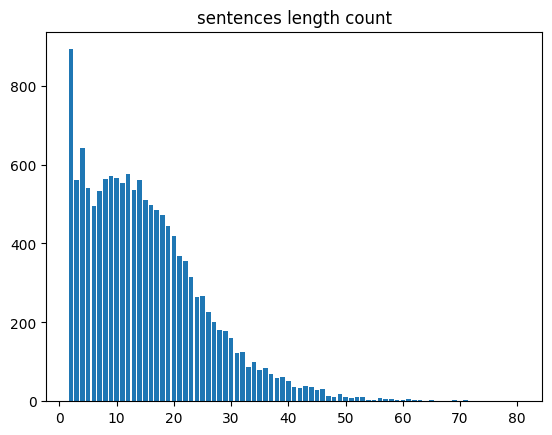

In [95]:
len_sentences = [len(s) for s in data_hmm]
counter = Counter(len_sentences)
print(counter)

plt.title("sentences length count")
plt.bar(counter.keys(), counter.values())


In [96]:
tagger = nltk.HiddenMarkovModelTagger.train(train_hmm)

In [97]:
pred_hmm_tag = [tag for _,tag in tagger.tag(test_word)]

In [98]:
accuracy_score(test_tag, pred_hmm_tag)

0.9253170720396948

In [99]:
f1_score(test_tag, pred_hmm_tag, average="weighted")


0.9245611032609682

## CRF

In [100]:
def features(sentence,index):
    return {
        # 'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
    }
  
def prepareData(tagged_sentences):
    X=[]
    for sentences in tagged_sentences:
        X.append([features(sentences, index) for index in range(len(sentences))])
    return X

In [101]:
sentences = []
tags = []
for sent in train_hmm:
    sent_word = []
    sent_tag = []
    for word, tag in sent:
        sent_word.append(word)
        sent_tag.append(tag)
    
    sentences.append(sent_word)
    tags.append(sent_tag)

In [102]:
len(sentences)

11293

In [103]:
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2)

In [104]:
X_train = prepareData(train_sentences)
y_train = train_tags
X_test = prepareData(test_sentences)
y_test =  test_tags

In [105]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

In [106]:
y_pred=crf.predict(X_test)
y_pred_train=crf.predict(X_train)

In [107]:
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

# #F1 score test
# print(metrics.flat_f1_score(y_test, y_pred,average='weighted',labels=crf.classes_))
# #Accuracy score test
# print(metrics.flat_accuracy_score(y_test,y_pred))

In [108]:
#F1 score train
print(metrics.flat_f1_score(y_train, y_pred_train,average='weighted',labels=crf.classes_))
#Accuracy score train
print(metrics.flat_accuracy_score(y_train,y_pred_train))

0.6990567241661743
0.7068886877828054


In [109]:
labels1=crf.classes_
print(len(labels1))
labels1

27


['<s>',
 'N',
 'A',
 'Np',
 'V',
 'M',
 'R',
 'E',
 '</s>',
 'Nu',
 'Nc',
 'L',
 'C',
 'X',
 'P',
 'Y',
 'Ny',
 'Nb',
 'T',
 'S',
 'I',
 'Vb',
 'B',
 'Eb',
 'Vy',
 'Ab',
 'H']

In [110]:
def crf_tagger(sent):
    sent = underthesea.word_tokenize(sent.lower())
    sent = ['<s>'] + sent + ['</s>']
    x_data = prepareData([sent])
    y_pred = crf.predict(x_data)
    return list(zip(sent, y_pred[0]))

sent = 'tôi yêu môn xử lí ngôn ngữ tự nhiên'
crf_tagger(sent)

[('<s>', '<s>'),
 ('tôi', 'N'),
 ('yêu', 'V'),
 ('môn', 'N'),
 ('xử lí', 'N'),
 ('ngôn ngữ', 'V'),
 ('tự nhiên', 'N'),
 ('</s>', '</s>')]

## Logistic Regression 

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [112]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()

In [113]:
Tfidf_vect = TfidfVectorizer()
wordvec = Tfidf_vect.fit_transform(all_words)

In [114]:
wordvec.shape

(172512, 11802)

In [115]:
len(Tfidf_vect.vocabulary_)
# print(Tfidf_vect.vocabulary_)

11802

In [116]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(wordvec, all_tags,test_size=0.2, random_state = 5)

In [117]:
print(Train_X.shape)
print(Test_X.shape)

(138009, 11802)
(34503, 11802)


In [118]:
classifier_lgr = LogisticRegression()
classifier_lgr.fit(Train_X,Train_Y)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [119]:
predictions_LGR = classifier_lgr.predict(Test_X)
accuracy_score(predictions_LGR, Test_Y)

0.7762513404631481

In [120]:
from sklearn.metrics import classification_report

In [121]:
print(classification_report(predictions_LGR, Test_Y))

              precision    recall  f1-score   support

        </s>       0.00      0.00      0.00         0
         <s>       1.00      0.33      0.49      7014
           A       0.63      0.89      0.73      1537
          Ab       0.00      0.00      0.00         0
           B       0.00      0.00      0.00         0
           C       0.84      0.94      0.89      1150
           E       0.83      0.82      0.83      2229
           I       0.00      0.00      0.00         0
           L       0.94      1.00      0.97       581
           M       0.76      0.97      0.85      1036
           N       0.90      0.91      0.90      8310
          Nb       0.43      1.00      0.60        37
          Nc       0.53      0.70      0.60       622
          Np       0.62      0.90      0.74       977
          Nu       0.68      0.60      0.64       179
          Ny       0.50      0.96      0.66        83
           P       0.97      0.93      0.95      1527
           R       0.79    

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r